In [36]:
import pandas as pd
import os 
import itertools
import statsmodels.api as sm
import matplotlib.pyplot as plt

import numpy as np
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Load the dataset
df = pd.read_csv(f"data/Top_12_German_Companies_Financial_Data.csv")  # Replace with actual path

In [37]:
print(df.head())

         Company      Period      Revenue    Net Income  Liabilities  \
0  Volkswagen AG   3/31/2017  19695988685  1.329398e+09  24520605687   
1  Volkswagen AG   6/30/2017   7201825633  7.220810e+08  27556950386   
2  Volkswagen AG   9/30/2017  15706422457  2.263166e+09  11556351337   
3  Volkswagen AG  12/31/2017   9750496618  5.168898e+08  21354201295   
4  Volkswagen AG   3/31/2018  15989256775  1.291419e+09  42659096630   

        Assets       Equity   ROA (%)    ROE (%)  Debt to Equity  
0  58120450678  33599844991  2.287315   3.956559        0.729783  
1  53860356064  26303405678  1.340654   2.745200        1.047657  
2  26096752248  14540400911  8.672214  15.564676        0.794775  
3  54861302788  33507101493  0.942176   1.542628        0.637304  
4  53863933584  11204836955  2.397558  11.525549        3.807204  


In [38]:
df.info()  # Check data types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Company         384 non-null    object 
 1   Period          384 non-null    object 
 2   Revenue         384 non-null    int64  
 3   Net Income      384 non-null    float64
 4   Liabilities     384 non-null    int64  
 5   Assets          384 non-null    int64  
 6   Equity          384 non-null    int64  
 7   ROA (%)         384 non-null    float64
 8   ROE (%)         384 non-null    float64
 9   Debt to Equity  384 non-null    float64
dtypes: float64(4), int64(4), object(2)
memory usage: 30.1+ KB


In [39]:
sap_df = df[df["Company"] == "SAP SE"].copy()

In [40]:
# Convert Period column to datetime format
sap_df["Period"] = pd.to_datetime(sap_df["Period"], format="%m/%d/%Y")

# Sort data by Period for proper time-series analysis
sap_df = sap_df.sort_values(by="Period")

In [41]:
sap_df.head()

,Company,Period,Revenue,Net Income,Liabilities,Assets,Equity,ROA (%),ROE (%),Debt to Equity
224,SAP SE,2017-03-31,6568715630,7.190910e+08,18570025227,65782612977,47212587750,1.093132,1.523092,0.393328
225,SAP SE,2017-06-30,6644029236,7.448730e+08,11294935497,23437806831,12142871334,3.178083,6.134241,0.930170
226,SAP SE,2017-09-30,18227487487,1.997619e+09,40486058249,55383211771,14897153522,3.606903,13.409398,2.717704
227,SAP SE,2017-12-31,17560385805,2.276361e+09,40828269592,73785136305,32956866713,3.085121,6.907091,1.238840
228,SAP SE,2018-03-31,19774628627,1.421901e+09,42095348780,63447988091,21352639311,2.241049,6.659133,1.971435


In [42]:
sap_df.tail()

,Company,Period,Revenue,Net Income,Liabilities,Assets,Equity,ROA (%),ROE (%),Debt to Equity
251,SAP SE,2023-12-31,13414872686,1.069408e+09,35679098743,80239095201,44559996459,1.332777,2.399929,0.800698
252,SAP SE,2024-03-31,13351789947,7.613065e+08,45369290420,94052696634,48683406213,0.809447,1.563791,0.931925
253,SAP SE,2024-06-30,8144018454,5.292574e+08,31360696540,57876694077,26515997537,0.914457,1.995993,1.182709
254,SAP SE,2024-09-30,10824151396,8.302800e+08,42369695133,72342104340,29972409208,1.147713,2.770148,1.413623
255,SAP SE,2024-12-31,16754700510,9.230066e+08,49206362475,96053458782,46847096308,0.960930,1.970254,1.050361


In [43]:
# Set period as index
sap_df.set_index("Period", inplace=True)

# Convert revenue to numeric
sap_df["Revenue"] = pd.to_numeric(sap_df["Revenue"], errors="coerce")

series = sap_df['Revenue']

In [44]:
# Check stationarity with Augmented Dickey-Fuller test
adf_test = adfuller(series)
adf_p_value = adf_test[1]
print(f"p-value: {adf_p_value}")

p-value: 0.0003727414710401756


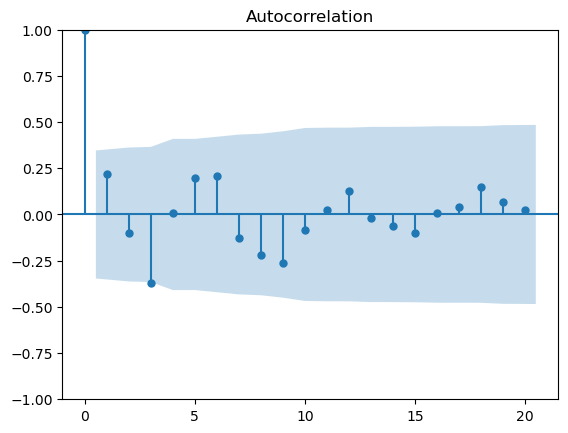

In [45]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=20)  # See if there’s a peak around lag=12
plt.show()

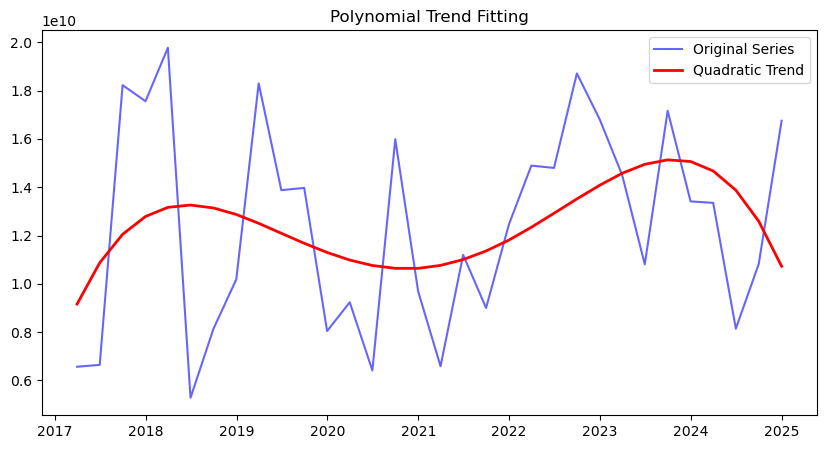

In [46]:
from numpy.polynomial.polynomial import Polynomial

# Create time index
X = np.arange(len(series))  # Convert years to numerical values
y = series.values

# Fit a 2nd-degree polynomial trend model
p = Polynomial.fit(X, y, deg=4)

# Plot trend
plt.figure(figsize=(10, 5))
plt.plot(series, label="Original Series", color="blue", alpha=0.6)
plt.plot(series.index, p(X), label="Quadratic Trend", color="red", linewidth=2)
plt.legend()
plt.title("Polynomial Trend Fitting")
plt.show()

<Figure size 1200x800 with 0 Axes>

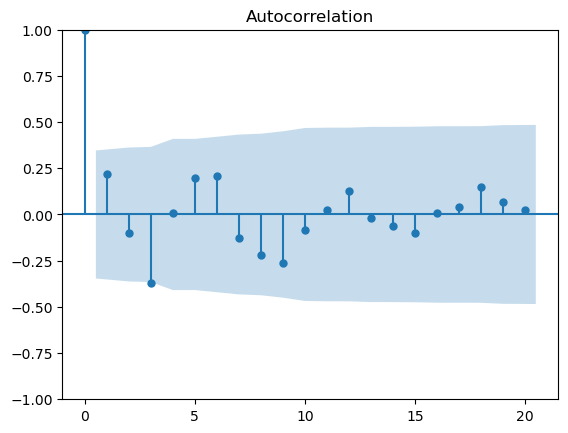

In [47]:
fig = plt.figure(figsize=(12, 8))

# ACF (for q selection)
sm.graphics.tsa.plot_acf(series.dropna(), lags=20)
plt.show()


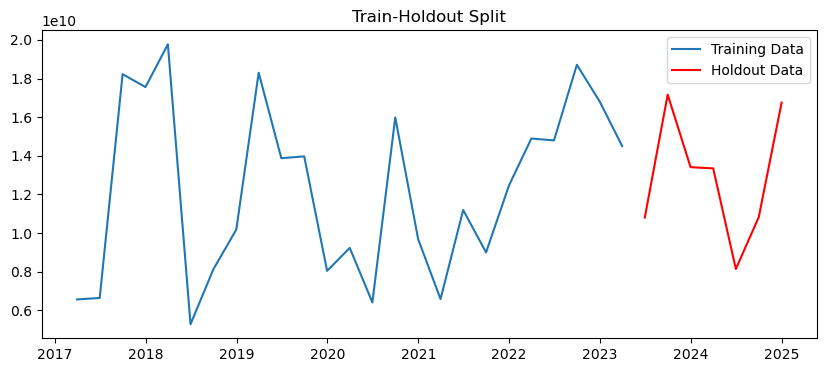

In [48]:
# Assuming 'series' is your Pandas Series with a DateTime index
train_size = int(len(series) * 0.8)  # 80% train, 20% holdout
train, holdout = series.iloc[:train_size], series.iloc[train_size:]

# Plot train/holdout split
plt.figure(figsize=(10, 4))
plt.plot(train, label="Training Data")
plt.plot(holdout, label="Holdout Data", color="red")
plt.title("Train-Holdout Split")
plt.legend()
plt.show()

In [49]:
# Split data into train and test (80% train, 20% test)
split_index = int(len(series) * 0.9)
train, test = series[:split_index], series[split_index:]

c:\Users\topra\miniconda3\envs\forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\topra\miniconda3\envs\forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\topra\miniconda3\envs\forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\topra\miniconda3\envs\forecasting\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QE-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\topra\miniconda3\envs\forecasting\lib\site-packages\statsmodels\tsa\base\tsa_mo

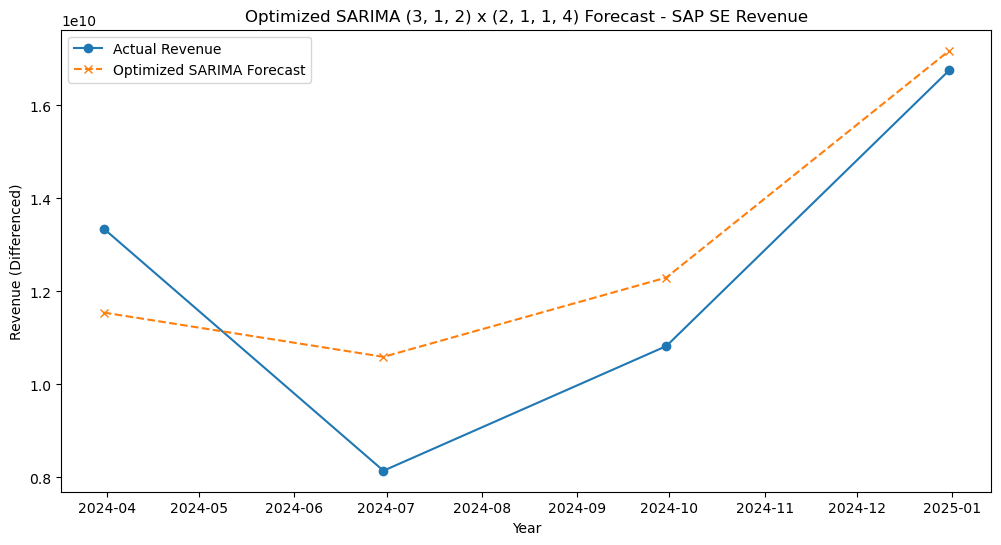

((3, 1, 2, 2, 1, 1), 1537905107.7985992, 1703782942.02548)

In [50]:


# Define parameter ranges for SARIMA tuning
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)
P_values = range(0, 3)
D_values = range(0, 2)
Q_values = range(0, 3)
S = 4  # Quarterly seasonality

best_score, best_cfg = float("inf"), None

# Grid search over SARIMA parameter combinations
for p, d, q, P, D, Q in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values):
    try:
        model = SARIMAX(train, order=(p, d, q), seasonal_order=(P, D, Q, S), enforce_stationarity=False, enforce_invertibility=False)
        model_fit = model.fit(disp=False)
        predictions = model_fit.forecast(steps=len(test))
        error = mean_absolute_error(test, predictions)
        if error < best_score:
            best_score, best_cfg = error, (p, d, q, P, D, Q)
    except:
        continue

# Train best SARIMA model
best_p, best_d, best_q, best_P, best_D, best_Q = best_cfg
optimized_model = SARIMAX(train, order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, S),
                          enforce_stationarity=False, enforce_invertibility=False)
optimized_model_fit = optimized_model.fit(disp=False)

# Predict with the optimized SARIMA model
optimized_predictions = optimized_model_fit.forecast(steps=len(test))

# Calculate new performance metrics
optimized_mae = mean_absolute_error(test, optimized_predictions)
optimized_rmse = np.sqrt(mean_squared_error(test, optimized_predictions))

# Plot optimized forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label="Actual Revenue", marker="o")
plt.plot(test.index, optimized_predictions, label="Optimized SARIMA Forecast", linestyle="dashed", marker="x")
plt.xlabel("Year")
plt.ylabel("Revenue (Differenced)")
plt.title(f"Optimized SARIMA ({best_p}, {best_d}, {best_q}) x ({best_P}, {best_D}, {best_Q}, {S}) Forecast - SAP SE Revenue")
plt.legend()
plt.show()

# Display optimized results
best_cfg, optimized_mae, optimized_rmse


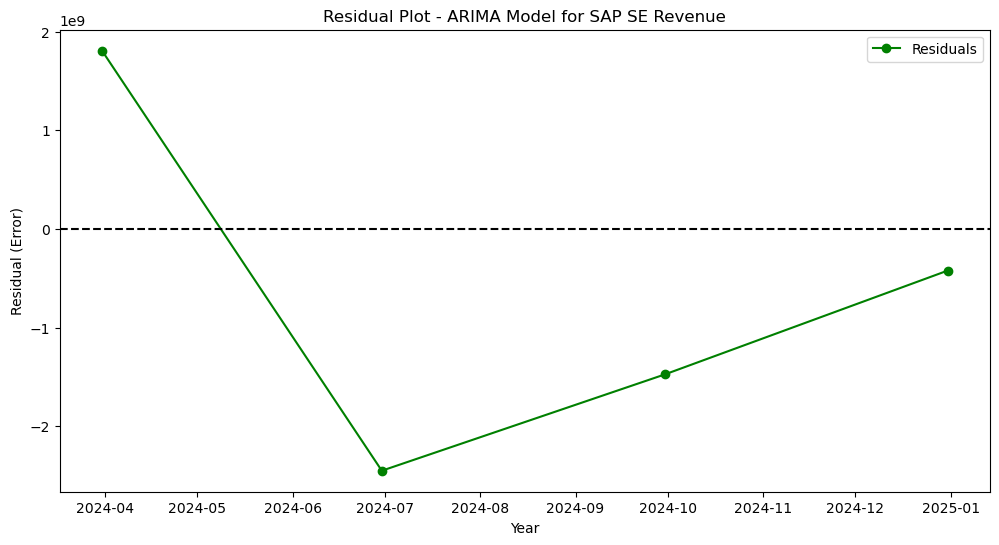

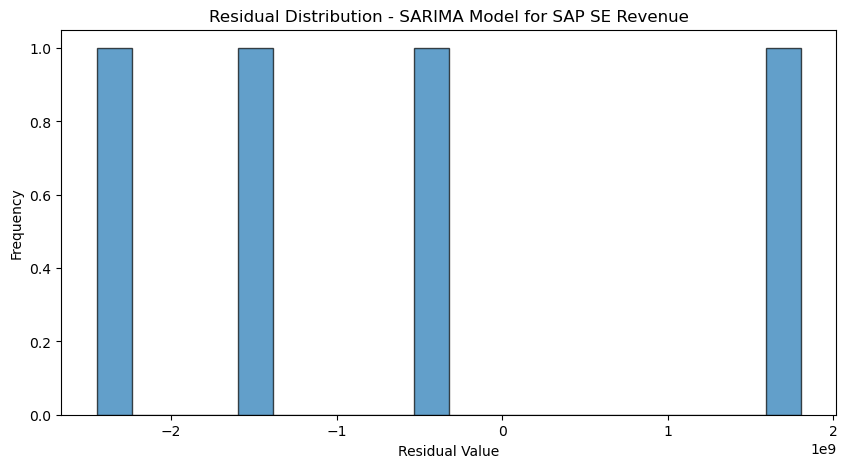

In [51]:
# Plot Residuals to Check Model Fit
residuals = test - optimized_predictions

plt.figure(figsize=(12, 6))
plt.plot(test.index, residuals, label="Residuals", marker="o", color="green")
plt.axhline(y=0, color='black', linestyle="dashed")
plt.xlabel("Year")
plt.ylabel("Residual (Error)")
plt.title("Residual Plot - ARIMA Model for SAP SE Revenue")
plt.legend()
plt.show()

# Histogram of Residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel("Residual Value")
plt.ylabel("Frequency")
plt.title("Residual Distribution - SARIMA Model for SAP SE Revenue")
plt.show()